# Electricity price analysis 

## Import & pre-process data 

In [54]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn import linear_model
import math


In [55]:
path='data/ESP/'
dataset_input = pd.read_csv(path+'historical_data.csv', sep= ';')
dataset_input['ETS']= np.zeros( len(dataset_input))
ETS_prices = pd.read_csv(path+'EUETSPrices.csv', sep=',')
date=dataset_input['Time (CET)'].iloc[0]
ETS_prices.Date = pd.to_datetime(ETS_prices.Date)
ETS_prices = ETS_prices.set_index('Date')
ETS_prices = ETS_prices.resample('H').fillna(method='ffill')

for i in range(len(dataset_input)):
    dataset_input['Time (CET)'][i] = dataset_input['Time (CET)'][i][:16]
dataset_input['Time (CET)'] = pd.to_datetime(dataset_input['Time (CET)'], utc=True, dayfirst=True)
dataset_input = dataset_input.set_index('Time (CET)')
dataset_input.ETS = ETS_prices
dataset_input.resample('H').fillna(method='ffill')
gas_prices = pd.read_csv(path+'bloc_ttf_prices.csv', sep=';')
gas_prices.Date = pd.to_datetime(gas_prices.Date, utc=True, dayfirst=True)

gas_prices = gas_prices.set_index('Date')
gas_prices = gas_prices.resample('H').fillna(method='ffill')
dataset_input['Gas prices'] = gas_prices
dataset_input= dataset_input.fillna(method='ffill')

coal_prices = pd.read_csv(path+'coal_prices.csv', sep=';')
coal_prices.Date = pd.to_datetime(coal_prices.Date, utc=True, dayfirst=True)
coal_prices = coal_prices.set_index('Date')
coal_prices = coal_prices.resample('H').fillna(method='ffill')
dataset_input['Coal prices']=coal_prices
dataset_input= dataset_input.fillna(method='ffill')
dataset_input

<ipython-input-55-226bb5618015>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_input['Time (CET)'][i] = dataset_input['Time (CET)'][i][:16]


,Demand,Imports,Exports,Price,Hydro,Nuclear,Other renewable,Solar,Wind,ETS,Gas prices,Coal prices
Time (CET),,,,,,,,,,,,
2021-03-01 00:00:00+00:00,23841.0,0,2476,35.38,6053,7110.0,96.0,4.0,11595,37.13,16.43,64.80
2021-03-01 01:00:00+00:00,22254.0,0,3647,32.90,7002,7109.0,97.0,4.0,10731,37.13,16.43,64.80
2021-03-01 02:00:00+00:00,21433.0,0,4271,27.60,7465,7108.0,96.0,4.0,9914,37.13,16.43,64.80
2021-03-01 03:00:00+00:00,21055.0,0,4284,26.60,6928,7108.0,98.0,3.0,9387,37.13,16.43,64.80
2021-03-01 04:00:00+00:00,20964.0,0,4347,26.74,6555,7109.0,98.0,3.0,8818,37.13,16.43,64.80
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 19:00:00+00:00,30845.0,2137,1710,134.07,3061,6946.0,104.0,2630.0,5663,60.76,50.43,153.75
2021-08-31 20:00:00+00:00,31079.0,2302,662,134.90,3980,6947.0,104.0,813.0,5927,60.76,50.43,153.75
2021-08-31 21:00:00+00:00,31986.0,2436,370,137.46,4353,6948.0,102.0,419.0,6403,60.76,50.43,153.75


In [56]:
from sklearn import preprocessing, linear_model
X = np.array(dataset_input.drop(columns=['Price']))
Y = np.array(dataset_input.Price)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
reg = linear_model.LinearRegression().fit(X_scaled, Y)
global_coeff= reg.coef_

In [57]:
coeff_day = np.zeros(X.shape)
for i in range (len(dataset_input)-1) :
    x= X_scaled[i:i+2]
    y = Y[i:i+2]
    reg = linear_model.LinearRegression().fit(x, y)
    coeff_day[i]=reg.coef_

In [31]:
import matplotlib.pyplot as plt
coeff_dataframe = pd.DataFrame(coeff_day, columns=['Demand', 'Imports', 'Exports', 'Hydro', 'Nuclear',
       'Other renewable', 'Solar', 'Wind', 'ETS', 'Gas prices', 'Coal prices'])
coeff_dataframe.head(24)

,Demand,Imports,Exports,Hydro,Nuclear,Other renewable,Solar,Wind,ETS,Gas prices,Coal prices
0,0.664922,0.000000,-1.589945,-1.077674,-0.155901,-0.255222,0.000000,0.661819,0.000000,0.000000,0.00000
1,3.156865,0.000000,-5.639806,-3.461816,-2.982177,1.789116,0.000000,3.231721,0.000000,0.000000,0.00000
2,0.610210,0.000000,-0.354290,1.618600,0.000000,-1.163047,-0.152558,0.490516,0.000000,0.000000,0.00000
3,6.446426,0.000000,-0.551195,-3.206798,-5.832842,0.000000,0.000000,2.347254,0.000000,0.000000,0.00000
4,-9.582995,0.000000,-5.386421,-2.225106,0.000000,1.428604,6.147170,-6.194058,0.000000,0.000000,0.00000
5,4.617345,2.681026,-1.751405,-1.692045,0.000000,-1.405915,0.003872,-0.252362,0.000000,0.000000,0.00000
6,5.842215,10.954690,-18.946497,-1.003097,18.384943,12.176021,9.329761,-0.370673,0.000000,0.000000,0.00000
7,0.518975,0.251724,0.380300,0.954069,-0.365684,1.071469,0.062145,-0.235486,0.000000,0.000000,0.00000
8,2.230222,2.768612,-22.319727,-1.311996,0.000000,5.989255,1.405775,-11.048345,0.000000,0.000000,0.00000
9,-3.489810,-1.008857,0.036190,0.117999,-22.292009,-11.851223,1.043297,0.924701,0.000000,0.000000,0.00000


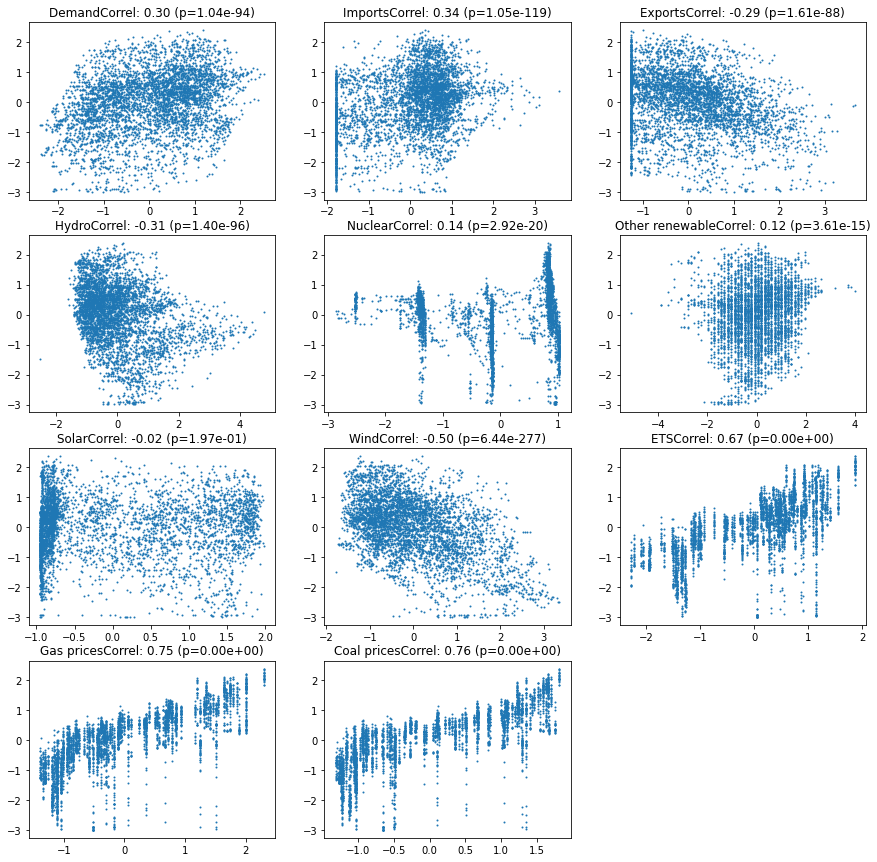

In [13]:
import scipy.stats as st

X = np.array(dataset_input)

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
standardized_data=pd.DataFrame(X_scaled, columns=['Demand', 'Imports', 'Exports','Price', 'Hydro', 'Nuclear', 'Other renewable', 'Solar', 'Wind', 'ETS', 'Gas prices', 'Coal prices'])


inputs = ['Demand', 'Imports', 'Exports', 'Hydro', 'Nuclear', 'Other renewable', 'Solar', 'Wind', 'ETS', 'Gas prices', 'Coal prices']
plt.figure(figsize=(15,15))
for i in range (len(inputs)) :
    x_data = standardized_data[inputs[i]]
    y_data = standardized_data['Price']
    r, pval = st.pearsonr(x_data, y_data)
    plt.subplot(4,3,i+1)
    plt.scatter(x_data, y_data, s=1)
    plt.title(inputs[i]+ "Correl: %.2f (p=%.2e)" % (r, pval))


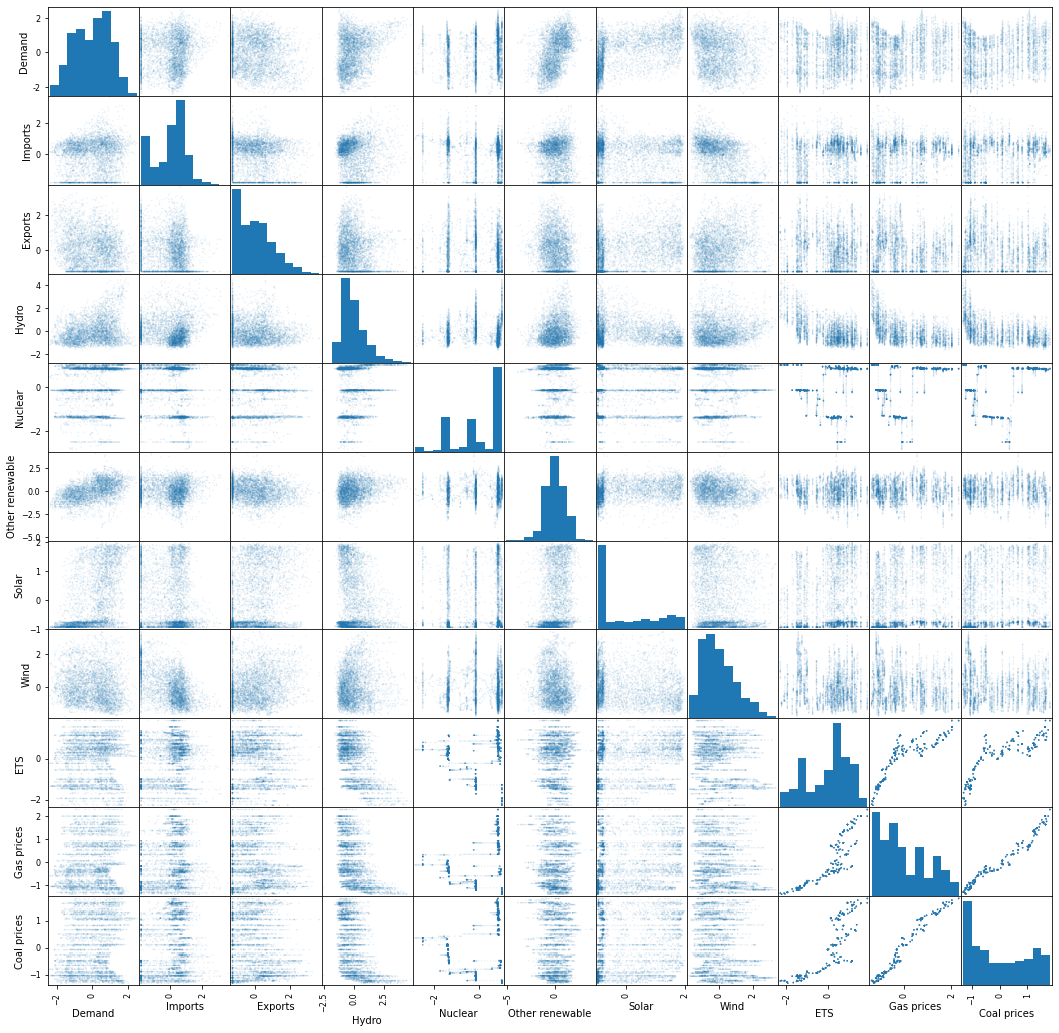

In [26]:
from pandas.plotting import scatter_matrix

scatter_matrix(standardized_data[['Demand', 'Imports', 'Exports', 'Hydro', 'Nuclear', 'Other renewable', 'Solar', 'Wind', 'ETS', 'Gas prices', 'Coal prices']], alpha=0.1, s=9,
               figsize=(18, 18));


In [36]:
x_data = standardized_data['Coal prices']
y_data = standardized_data['Gas prices']
r, pval = st.pearsonr(x_data, y_data)

In [69]:

# day based analysis 
coeff_day = np.zeros((24,10))
for h in range(24) :
    x_df = dataset_input.loc[dataset_input.index.hour==h]
    x = np.array(x_df.drop(columns=['Price', 'Coal prices']))
    std_scale = preprocessing.StandardScaler().fit(x)
    x_scaled = std_scale.transform(x)
    Y = np.array(x_df['Price'])
    reg = linear_model.LinearRegression().fit(x_scaled, Y)
    coeff_day[h]=reg.coef_


In [73]:
coeff_dataframe = pd.DataFrame(coeff_day, columns=['Demand', 'Imports', 'Exports', 'Hydro', 'Nuclear',
       'Other renewable', 'Solar', 'Wind', 'ETS', 'Gas prices'])
coeff_dataframe.describe()

,Demand,Imports,Exports,Hydro,Nuclear,Other renewable,Solar,Wind,ETS,Gas prices
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,9.024359,-4.433128,1.144400,-5.344522,-3.508117,-0.474286,-3.121177,-12.177984,1.115883,14.372987
std,3.131400,0.788738,0.689694,1.550098,0.657272,0.729481,2.159608,1.188200,2.157945,0.913584
min,3.873932,-5.796718,-0.545896,-7.727671,-4.737260,-2.002405,-6.860546,-13.634106,-2.773808,12.607056
25%,6.317636,-5.029529,0.832496,-6.743750,-3.950831,-0.722743,-4.630963,-12.991797,0.313644,13.865834
50%,9.317701,-4.418597,1.127620,-5.339126,-3.501124,-0.528604,-3.761215,-12.573859,1.382921,14.321005
75%,11.286938,-3.778226,1.493874,-4.295116,-3.217015,-0.083464,-0.945422,-11.714619,2.548459,14.733642
max,15.101770,-3.152018,3.045596,-1.700908,-1.962466,0.710766,-0.464641,-9.157549,4.848558,16.768969


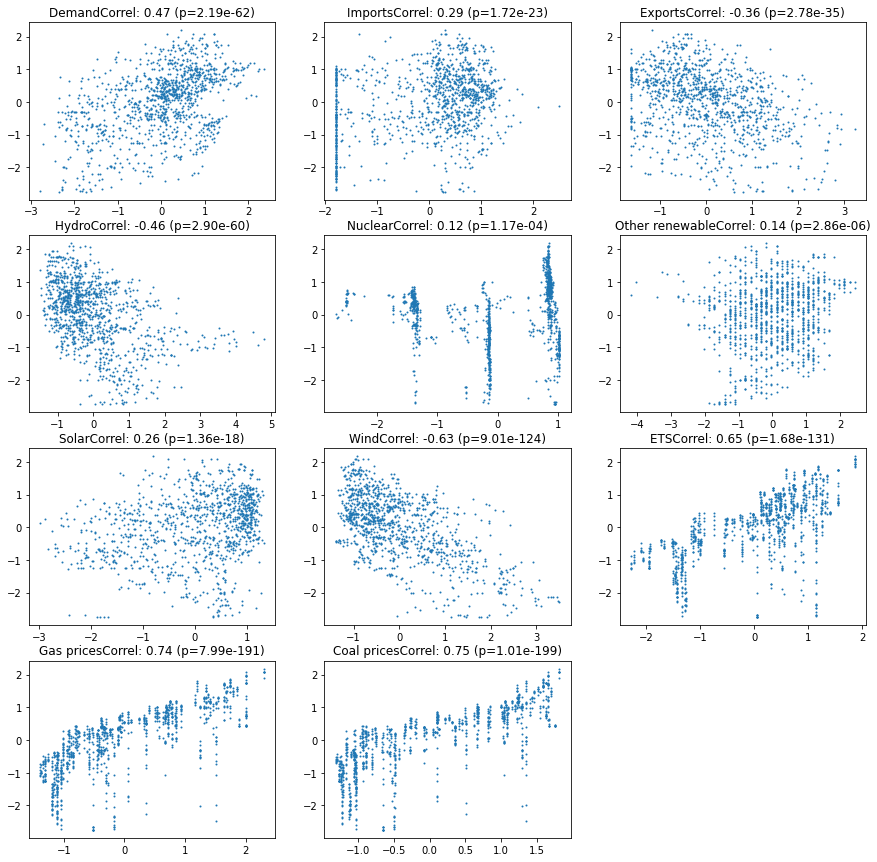

In [79]:
import scipy.stats as st

X = np.array(dataset_input.loc[(dataset_input.index.hour<16) & (dataset_input.index.hour>9)  ])
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
standardized_data=pd.DataFrame(X_scaled, columns=['Demand', 'Imports', 'Exports','Price', 'Hydro', 'Nuclear', 'Other renewable', 'Solar', 'Wind', 'ETS', 'Gas prices', 'Coal prices'])


inputs = ['Demand', 'Imports', 'Exports', 'Hydro', 'Nuclear', 'Other renewable', 'Solar', 'Wind', 'ETS', 'Gas prices', 'Coal prices']
plt.figure(figsize=(15,15))
for i in range (len(inputs)) :
    x_data = standardized_data[inputs[i]]
    y_data = standardized_data['Price']
    r, pval = st.pearsonr(x_data, y_data)
    plt.subplot(4,3,i+1)
    plt.scatter(x_data, y_data, s=1)
    plt.title(inputs[i]+ "Correl: %.2f (p=%.2e)" % (r, pval))
